<center><h1>Deltalake</h1></center>


<!DOCTYPE html>
<html lang="en">
<head>
    <meta charset="UTF-8">
    <meta name="viewport" content="width=device-width, initial-scale=1.0">
    <title>Author Details</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            background-color: #f9f9f9;
            margin: 0;
            padding: 20px;
            display: flex;
            justify-content: center;
            align-items: center;
            height: 100vh;
        }
        .author-card {
            background: white;
            border-radius: 10px;
            box-shadow: 0 0 10px rgba(0, 0, 0, 0.1);
            padding: 20px;
            width: 300px;
            text-align: center;
        }
        .author-card h2 {
            margin: 0;
            font-size: 24px;
            color: #333;
        }
        .author-card p {
            margin: 10px 0;
            color: #666;
        }
        .author-card .bio {
            font-size: 14px;
            line-height: 1.6;
        }
    </style>
</head>
<body>
    <div class="author-card">
        <h2>Nikhil Sharma</h2>
        <p><strong>Position:</strong>Data Engineer</p>
        <p><strong>Institution:</strong> KIRK YAGAMI CONSULTANCY SERVICES PRIVATE LIMITED</p>
        <p><strong>Email:</strong> <a href="mailto:author@example.com">er.nikhilshama7.com</a></p>
        <!-- <p class="bio">Short bio about the author. This section can include details about the author's background, achievements, and research interests.</p> -->
    </div>
</body>
</html>


```
Delta Lake is an open source storage layer that brings reliability to data lakes. Delta Lake provides ACID transactions, scalable metadata handling, and unifies streaming and batch data processing. Delta Lake runs on top of your existing data lake and is fully compatible with Apache Spark APIs.
```

https://docs.delta.io/latest/quick-start.html

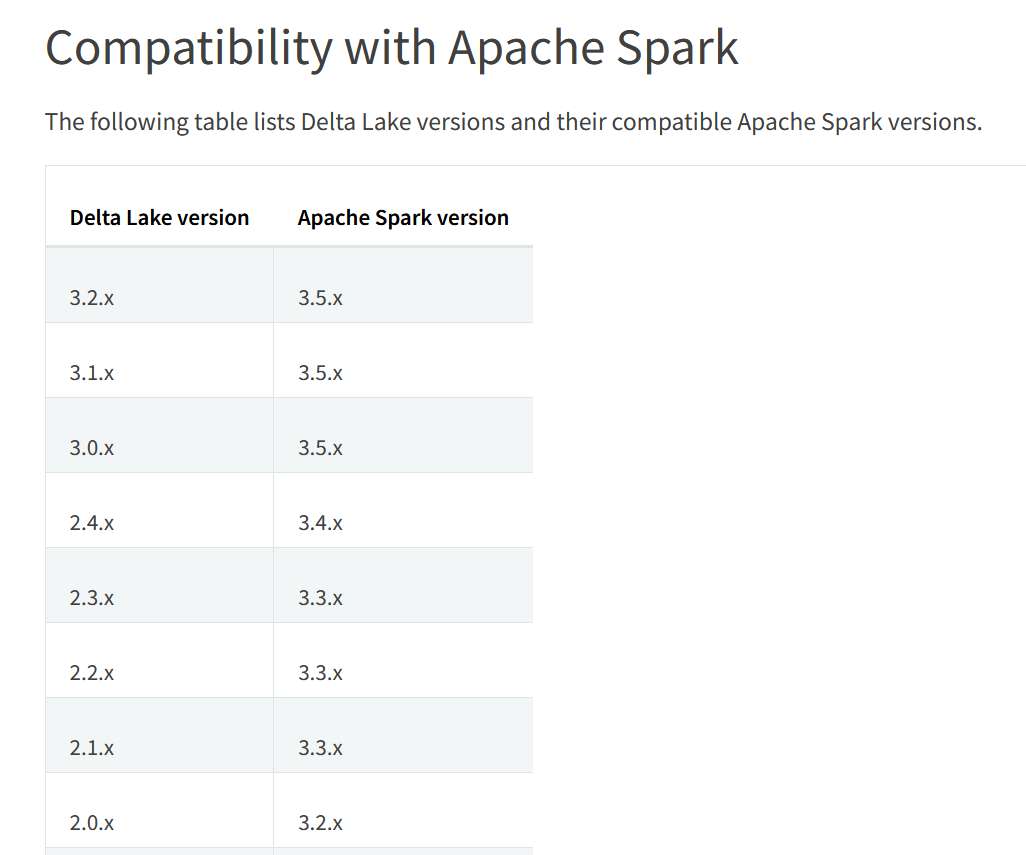

In [ ]:
# pip install delta-spark==2.3.0

In [1]:
import pyspark
from delta import *
from pyspark.sql.types import *
from delta.tables import *
from pyspark.sql import functions as F

#  Create a spark session with Delta
builder = pyspark.sql.SparkSession.builder.appName("DeltaTutorial") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")

# Create spark context
spark = configure_spark_with_delta_pip(builder).getOrCreate()
spark.sparkContext.setLogLevel("ERROR")

# Delta Features
## 1. Create a delta table

In [3]:
# Create a spark dataframe and write as a delta table
print("Starting Delta table creation")

data = [("Robert", "Baratheon", "Baratheon", "Storms End", 48),
        ("Eddard", "Stark", "Stark", "Winterfell", 46),
        ("Jamie", "Lannister", "Lannister", "Casterly Rock", 29)
        ]
schema = StructType([
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("house", StringType(), True),
    StructField("location", StringType(), True),
    StructField("age", IntegerType(), True)
])

sample_dataframe = spark.createDataFrame(data=data, schema=schema)
sample_dataframe.write.mode(saveMode="overwrite").format("delta").save("data/delta-table")

First we first define a spark data frame. In this case we have the schema and data for our favourite characters from Game of thrones. The magic line for storing that dataframe in delta format is the .format(“delta”) and then we specify the location to be the data folder that we created earlier.

As soon as we run the program, we can see the delta log and the snappy parquet files created.

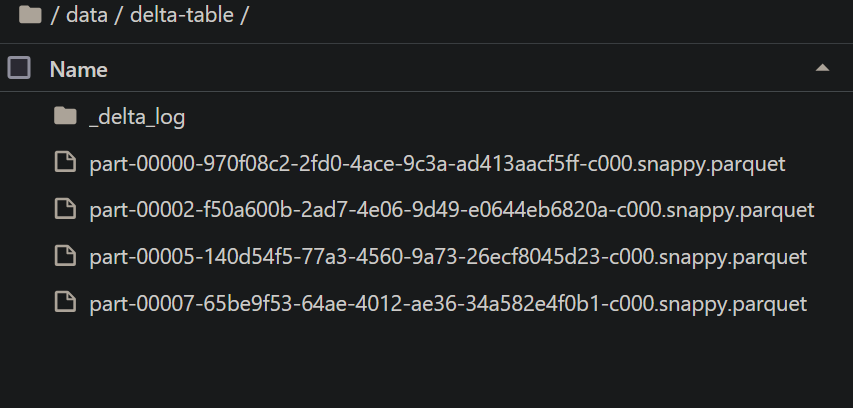

## 2. Read a delta table

Reading is as easy as again just specifing the the .format(“delta”) in the spark read api

In [4]:
# Read Data
print("Reading delta file ...!")

got_df = spark.read.format("delta").load("data/delta-table")
got_df.show()

Reading delta file ...!
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Casterly Rock| 29|
|   Robert|Baratheon|Baratheon|   Storms End| 48|
|   Eddard|    Stark|    Stark|   Winterfell| 46|
+---------+---------+---------+-------------+---+



### Update a delta table

### Overwrite whole table

`In case you want to simply overwrite the delta table you can simple provide the .mode(saveMode=”overwrite”) command`

In [6]:
# Update data
print("Updating Delta table...!")
data = [("Robert", "Baratheon", "Baratheon", "Storms End", 49),
        ("Eddard", "Stark", "Stark", "Winterfell", 47),
        ("Jamie", "Lannister", "Lannister", "Casterly Rock", 30)
        ]
schema = StructType([
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("house", StringType(), True),
    StructField("location", StringType(), True),
    StructField("age", IntegerType(), True)
])
sample_dataframe = spark.createDataFrame(data=data, schema=schema)
sample_dataframe.write.mode(saveMode="overwrite").format("delta").save("data/delta-table")

print("Done Updating the Delta table...!")

print("--------------------------------------------")

print("Reading Delta table...!")

updated_table = spark.read.format("delta").load("data/delta-table")
updated_table.show()

Updating Delta table...!
Done Updating the Delta table...!
--------------------------------------------
Reading Delta table...!
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Casterly Rock| 30|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+



## 3. Conditional Update

`If we want to update a record or few records according to a condition we can simple use the .update method like this`

In [9]:
# Update data in Delta
print("Update data...!")

# delta table path
deltaTable = DeltaTable.forPath(spark, "data/delta-table")
deltaTable.toDF().show()

deltaTable.update(
    condition=expr("firstname == 'Jamie'"),
    set={"firstname": F.lit("Jamie"), "lastname": F.lit("Lannister"), "house": F.lit("Lannister"),
         "location": F.lit("Kings Landing"), "age": F.lit(37)})

deltaTable.toDF().show()

Update data...!
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Casterly Rock| 30|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+

+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Kings Landing| 37|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+



In this case we updated the location and age of the records whose firstname was jamie. and we can see the result with before and after of the dataframe console output.

## 4. Upsert a delta table

Upsert is simple a combination of two operations (update and insert hence very intuitively called upsert). In order to upsert records we do something like

In [10]:
# Upsert Data
print("Upserting Data...!")
# delta table path
deltaTable = DeltaTable.forPath(spark, "data/delta-table")
deltaTable.toDF().show()

# define new data
data = [("Gendry", "Baratheon", "Baratheon", "Kings Landing", 19),
        ("Jon", "Snow", "Stark", "Winterfell", 21),
        ("Jamie", "Lannister", "Lannister", "Casterly Rock", 36)
        ]
schema = StructType([
    StructField("firstname", StringType(), True),
    StructField("lastname", StringType(), True),
    StructField("house", StringType(), True),
    StructField("location", StringType(), True),
    StructField("age", IntegerType(), True)
])

newData = spark.createDataFrame(data=data, schema=schema)

deltaTable.alias("oldData") \
    .merge(
    newData.alias("newData"),
    "oldData.firstname = newData.firstname") \
    .whenMatchedUpdate(
    set={"firstname": col("newData.firstname"), "lastname": col("newData.lastname"), "house": col("newData.house"),
         "location": col("newData.location"), "age": col("newData.age")}) \
    .whenNotMatchedInsert(
    values={"firstname": col("newData.firstname"), "lastname": col("newData.lastname"), "house": col("newData.house"),
            "location": col("newData.location"), "age": col("newData.age")}) \
    .execute()

deltaTable.toDF().show()

Upserting Data...!
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Kings Landing| 37|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+

+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|   Gendry|Baratheon|Baratheon|Kings Landing| 19|
|    Jamie|Lannister|Lannister|Casterly Rock| 36|
|      Jon|     Snow|    Stark|   Winterfell| 21|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+



`First we define a new data frame which has updates to jamie again with his age and then we have two new records for Jon Snow and Gendry Baratheon.`

`The magic function that we use for upsert is merge. In this case we assign alias to the old and new dataframes and set the rules of what to do if a record mathes with the existing data record. the condition we are looking for is “oldData.firstname = newData.firstname”. And if it matches we update everything to the new values`

In [ ]:
.whenMatchedUpdate(
    set={"firstname": col("newData.firstname"), "lastname": col("newData.lastname"), "house": col("newData.house"),
         "location": col("newData.location"), "age": col("newData.age")})

`If it doesn't we insert and execute`

In [ ]:
.whenNotMatchedInsert(
    values={"firstname": col("newData.firstname"), "lastname": col("newData.lastname"), "house": col("newData.house"),
            "location": col("newData.location"), "age": col("newData.age")}) \
    .execute()

if we take a look at before and after of our operation on the dataframe, we can clearly see that the records have been upserted correctly.

## Delete a delta table

`We can also delete a particular record based on filter just like we did for update`

In [11]:
# Delete Data
print("Deleting data...!")

# delta table path
deltaTable = DeltaTable.forPath(spark, "data/delta-table")
deltaTable.toDF().show()

deltaTable.delete(condition=expr("firstname == 'Gendry'"))
deltaTable.toDF().show()

Deleting data...!
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|   Gendry|Baratheon|Baratheon|Kings Landing| 19|
|    Jamie|Lannister|Lannister|Casterly Rock| 36|
|      Jon|     Snow|    Stark|   Winterfell| 21|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+

+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
|    Jamie|Lannister|Lannister|Casterly Rock| 36|
|      Jon|     Snow|    Stark|   Winterfell| 21|
+---------+---------+---------+-------------+---+



## Read Historic data for Delta Table

`Delta lake also allows you to read differnt historic versions of the data. the version history is stored in the _delta_log folder. we can inspect it to exactly know the kind of operation that happened on that point in time`

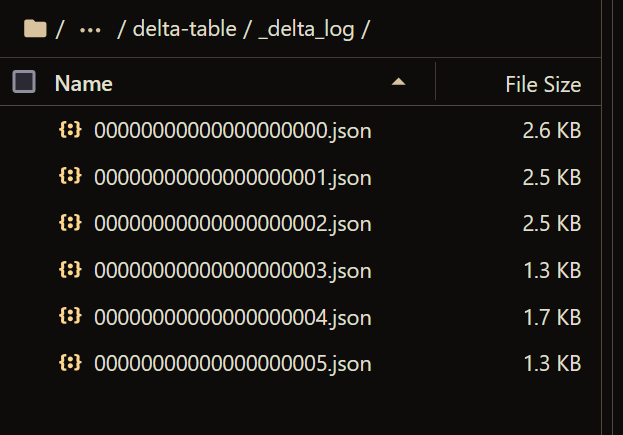

`In order to read the data we can specify versions and read like a normal dataframe.`

In [12]:
# Reading Older version of Data
print("Read old data...!\n")

print("V1")
df_versionzero = spark.read.format("delta").option("versionAsOf", 0).load("data/delta-table")
df_versionzero.show()

print("----------------------------------------\n")

print("V2")
df_versionzone = spark.read.format("delta").option("versionAsOf", 1).load("data/delta-table")
df_versionzone.show()
print("----------------------------------------\n")

print("V3")
df_versionzone = spark.read.format("delta").option("versionAsOf", 3).load("data/delta-table")
df_versionzone.show()

print("----------------------------------------\n")

print("V4")
df_versionzone = spark.read.format("delta").option("versionAsOf", 4).load("data/delta-table")
df_versionzone.show()


print("----------------------------------------\n")

print("V5")
df_versionzone = spark.read.format("delta").option("versionAsOf", 5).load("data/delta-table")
df_versionzone.show()


Read old data...!

V1
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Casterly Rock| 29|
|   Robert|Baratheon|Baratheon|   Storms End| 48|
|   Eddard|    Stark|    Stark|   Winterfell| 46|
+---------+---------+---------+-------------+---+

----------------------------------------

V2
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Casterly Rock| 30|
|   Robert|Baratheon|Baratheon|   Storms End| 49|
|   Eddard|    Stark|    Stark|   Winterfell| 47|
+---------+---------+---------+-------------+---+

----------------------------------------

V3
+---------+---------+---------+-------------+---+
|firstname| lastname|    house|     location|age|
+---------+---------+---------+-------------+---+
|    Jamie|Lannister|Lannister|Kings

```
We can see the data updated in the console.

There is a lot more that Delta lake and Lakehouse offers than we covered here. Please check out the official documentation which has a lot of easy to grasp examples.

https://docs.delta.io/latest/delta-intro.html

Happy Learning !
```